This notebook adresseses an employee scheduling problem involving multiple employees and tasks.

The objective studied is maximizing total number of tasks completed within available times of employees.

Each task can be assigned to at most one employee and **preemption** is allowed. An execution of a task can be interrupted  and continued at a later time at the same employee.  The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any employee. Finally, employees are associated with availability start and end times.

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

DATAFILE_PATH = os.path.join("data", "MasterData.xlsx")
NB_EMPLOYEES = 5
NB_TASKS = 25

# READ DATA

In [2]:
employeesTable = pd.read_excel(DATAFILE_PATH, sheet_name='Employees', header=0)
employeesTable = employeesTable.head(NB_EMPLOYEES) # select only NB_EMPLOYEES employees in order to have a small-sized problem
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate
0,Anne,480,1020,11,1,25
1,Bethanie,480,1020,4,5,28
2,Betsy,480,1020,2,2,17
3,Cathy,480,1020,2,2,17
4,Cecilia,480,1020,9,5,38


In [3]:
tasksTable = pd.read_excel(DATAFILE_PATH, sheet_name='Tasks', header=0)
tasksTable = tasksTable.head(NB_TASKS) # select only NB_TASKS tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Geriatrics,70,1
1,T002,Pediatrics,100,1
2,T003,Cardiac Care,90,1
3,T004,Oncology,110,1
4,T005,Anaesthesiology,50,2
5,T006,Cardiac Care,50,1
6,T007,Anaesthesiology,90,1
7,T008,Anaesthesiology,70,2
8,T009,Cardiac Care,80,1
9,T010,Oncology,100,1


In [4]:
# subtasks with size of 1 are created in order to make tasks fully preemptive
subTasksTable = tasksTable.loc[tasksTable.index.repeat(tasksTable['task_duration'])].reset_index(drop=True)
subTasksTable['index_within_group'] = subTasksTable.groupby('task_id').cumcount() + 1
subTasksTable

,task_id,task_type,task_duration,required_nbr_of_employees,index_within_group
0,T001,Geriatrics,70,1,1
1,T001,Geriatrics,70,1,2
2,T001,Geriatrics,70,1,3
3,T001,Geriatrics,70,1,4
4,T001,Geriatrics,70,1,5
...,...,...,...,...,...
2075,T025,Oncology,90,1,86
2076,T025,Oncology,90,1,87
2077,T025,Oncology,90,1,88
2078,T025,Oncology,90,1,89


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame.

In [5]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
#employees 

In [6]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
#tasks 

In [7]:
subTasksT  = namedtuple("subTasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees','index'])
subTasks  = [subTasksT(*subTasks_row) for subTasks_row in subTasksTable.itertuples(index=False)]
#subTasks

# CREATE A MODEL INSTANCE

In [8]:
from docplex.cp.model import CpoModel
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [9]:
BIG_NUM = 9999
# define processing interval of each task at each employee
tasks_itv_vars = {}   
for e in employees:
    for t in tasks:
        tasks_itv_vars[t,e] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=(t.taskDuration, BIG_NUM), name="interval_task{}_employee{}".format(t.taskId,e.name))
        #print(tasks_itv_vars[t,e])

In [10]:
# define break interval for each employee
break_earliest_start = 660
break_latest_end = 780
break_duration = 60
break_itv_vars = {}
for e in employees:
    break_itv_vars[e] = mdl.interval_var(start=(break_earliest_start,break_latest_end), end=(break_earliest_start,break_latest_end), optional=True, size=(break_duration), name="break_interval_employee{}".format(e.name))
    #print (break_itv_vars[e])

In [11]:
# define production processing interval of each job at each machine
sub_tasks_itv_vars = {}   # dict of interval variable for each transaction
#tasks_itv_vars = [[mdl.interval_var(optional=True, size=t.taskDuration, name="interval_task{}_employee{}".format(t.taskId,e.name)) for e in employees] for t in tasks] 
for e in employees:
    for t in tasks:
        for i in range(1,t.taskDuration+1):
            sub_tasks_itv_vars[t,e,i] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=1, name="sub_interval_task{}_employee{}_subTask{}".format(t.taskId,e.name,i))
            #print(sub_tasks_itv_vars[t,e,i])

# EXPRESS OBJECTIVE FUNCTION

In [12]:
# minimize makespan
objective = mdl.sum([mdl.end_of(tasks_itv_vars[t,e]) for t in tasks for e in employees])
mdl.add(mdl.minimize(objective)) 

# DEFINE CONSTRAINTS

In [13]:
# each task should be assigned to an employee
for t in tasks:
    mdl.add(mdl.sum([mdl.presence_of(tasks_itv_vars[t,e]) for e in employees]) == 1)

In [14]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap([sub_tasks_itv_vars[t,e,i] for t in tasks for i in range(1,t.taskDuration+1) ] + [break_itv_vars[e]] ))
    mdl.add(mdl.no_overlap([tasks_itv_vars[t,e] for t in tasks]))

In [15]:
# ensure that if an employee has a task assigned, that employee should take a break
for e in employees:
    mdl.add(mdl.presence_of(break_itv_vars[e]) == mdl.any([mdl.presence_of(tasks_itv_vars[t,e]) for t in tasks]))

In [16]:
# task intervals should span over subtask intervals and it is ensured that if a task interval is present, then its all subtasks should be present
for e in employees:
    for t in tasks:
        mdl.add(mdl.span(tasks_itv_vars[t,e], [sub_tasks_itv_vars[t,e,i] for i in range(1,t.taskDuration+1)])) 
        mdl.add(mdl.presence_of(tasks_itv_vars[t,e])*t.taskDuration==mdl.sum(mdl.presence_of(sub_tasks_itv_vars[t,e,i]) for i in range(1,t.taskDuration+1))) 

In [17]:
# ensure subtasks are ordered correctly
for e in employees:
    for t in tasks:
        for i in range(2,t.taskDuration+1):
            mdl.add(mdl.end_before_start(sub_tasks_itv_vars[t,e,i-1],sub_tasks_itv_vars[t,e,i]))
            mdl.add(mdl.presence_of(sub_tasks_itv_vars[t,e,i])<=mdl.presence_of(sub_tasks_itv_vars[t,e,i-1]))             

# SOLVE THE MODEL

In [18]:
msol = mdl.solve(TimeLimit=60,
                 log_output=True, # set to None to suppress output
                 LogPeriod=1_000_000,
                )
# print("Solution: ")
# msol.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 10540 variables, 20840 constraints
 ! Presolve      : 10275 extractables eliminated
 ! TimeLimit            = 60
 ! LogPeriod            = 1000000
 ! Initial process time : 6.38s (6.39s extraction + 0.00s propagation)
 !  . Log search space  : 93165.1 (before), 93165.1 (after)
 !  . Memory usage      : 116.2 MB (before), 116.2 MB (after)
 ! Using parallel search with 10 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0      10540                 -
 + New bound is 0
 ! Using iterative diving.
 *         19330     4171  22.55s       1      (gap is 100.0%)
 *         19150    12889  25.22s       1      (gap is 100.0%)
 *         19140    17059  26.97s       1      (gap is 100.0%)
 *         19000    37910  36.42s       2      (gap is 100.0%)
 *         18720

# PREPARE OUTPUT TABLES

In [19]:
assignmentReport = [(e.name, t.taskId, t.taskDuration, 
                     msol.get_var_solution(tasks_itv_vars[t,e]).get_start(),msol.get_var_solution(tasks_itv_vars[t,e]).get_end()) 
                       for t in tasks for e in employees if msol.get_var_solution(tasks_itv_vars[t,e]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Duration','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
assignmentReport_df

,Employee,Task,Duration,StartTime,EndTime
5,Anne,T006,50,480,530
0,Anne,T001,70,530,600
20,Anne,T021,50,600,650
9,Anne,T010,100,650,810
17,Anne,T018,110,810,920
24,Bethanie,T025,90,480,570
18,Bethanie,T019,70,570,640
10,Bethanie,T011,80,640,780
2,Bethanie,T003,90,780,870
6,Bethanie,T007,90,870,960


In [20]:
subAssignmentReport = [(e.name, t.taskId,  t.taskDuration , i, 
                        msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).get_start(),msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).get_end()) 
                       for t in tasks for e in employees for i in range(1,t.taskDuration+1) 
                       if msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).is_present()]
subAssignmentReport_df = pd.DataFrame(subAssignmentReport, columns=['Employee', 'Task', 'Duration','Index','StartTime','EndTime'])
subAssignmentReport_df = subAssignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
subAssignmentReport_df 

,Employee,Task,Duration,Index,StartTime,EndTime
420,Anne,T006,50,1,480,481
421,Anne,T006,50,2,481,482
422,Anne,T006,50,3,482,483
423,Anne,T006,50,4,483,484
424,Anne,T006,50,5,484,485
...,...,...,...,...,...,...
1355,Cecilia,T016,100,96,995,996
1356,Cecilia,T016,100,97,996,997
1357,Cecilia,T016,100,98,997,998
1358,Cecilia,T016,100,99,998,999


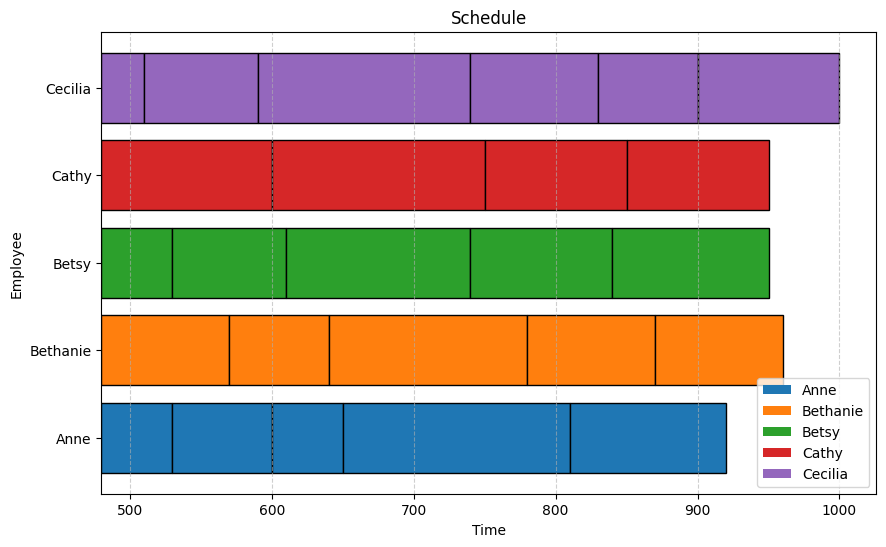

In [21]:
# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0),1,1,fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()